# Student Depression Analysis
学生抑郁症分析：通过一些特征，来尝试分析出学生是否有抑郁症  
分析：此问题为一个二分类问题，即给定一些特征，判断学生是否抑郁症即可，作为我的第一个机器学习项目。（自主学习项目）  
想法：尝试使用Pytorch构建神经网络，参考之前学的二分类基础模型代码，尝试进行训练构建。  

## 0. 导入必要的依赖包和设置一些基本设置

In [165]:
# 导入PyTorch
import torch
#  导入数据处理包
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

#设置使用CUDA 还是 CPU进行训练（这里可以只用CPU训练）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 设置随机种子，确保结果可复现
RANDOM_SEED = 42

import kagglehub
adilshamim8_student_depression_dataset_path = kagglehub.dataset_download('adilshamim8/student-depression-dataset')
print('Data source import complete.')


100%|██████████| 456k/456k [00:00<00:00, 621kB/s]

Extracting files...
Data source import complete.


## 1. 数据处理
读取CSV文件  

In [166]:
 # 加载数据集
df = pd.read_csv('./Data/archive/student_depression_dataset.csv')
df.head() # 显示前五行


,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,'5-6 hours',Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,'5-6 hours',Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,'Less than 5 hours',Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,'7-8 hours',Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,'5-6 hours',Moderate,M.Tech,Yes,1.0,1.0,No,0


### 1.1 数据清洗  

#### 1.1.1 EDA Exploratory Data Analysis 探索性数据分析
为系统性探索数据特征的过程  
目标包括：  
1. 理解数据分布（如数值范围、类别平衡）
2. 识别数据问题（缺失值，异常值，重复数据）  
3. 发现潜在模式（特征间相关性、聚类趋势）  
4. 指导清洗策略（决定如何处理缺失或异常）  

|    操作类型    |         工具/方法         |              目的              |
| :------------: | :-----------------------: | :----------------------------: |
|   缺失值分析   |     `.isnull().sum()`     |         统计各列缺失率         |
|   异常值检测   |  箱线图（`sns.boxplot`）  |     识别超出合理范围的数值     |
| 数据分布可视化 |   直方图（`plt.hist`）    |    检查偏态、峰态等分布特征    |
|  类别平衡检查  | 条形图（`sns.countplot`） |       发现类别不平衡问题       |
|  重复数据筛查  |   `.duplicated().sum()`   |           定位重复行           |
| 特征相关性分析 |  热力图（`sns.heatmap`）  | 识别高相关特征，避免多重共线性 |

------


In [174]:
# 1. 基础统计
print("数据集的基本统计信息：") 
print(df.describe()) # 显示数据集的基本统计信息
print("数据集名称，行数，数值，类型：")
print(df.info()) # 显示数据集的信息，包括数据类型和缺失值情况

数据集的基本统计信息：
                  id           Age  Academic Pressure  Work Pressure  \
count   27901.000000  27901.000000       27901.000000   27901.000000   
mean    70442.149421     25.822300           3.141214       0.000430   
std     40641.175216      4.905687           1.381465       0.043992   
min         2.000000     18.000000           0.000000       0.000000   
25%     35039.000000     21.000000           2.000000       0.000000   
50%     70684.000000     25.000000           3.000000       0.000000   
75%    105818.000000     30.000000           4.000000       0.000000   
max    140699.000000     59.000000           5.000000       5.000000   

               CGPA  Study Satisfaction  Job Satisfaction  Work/Study Hours  \
count  27901.000000        27901.000000      27901.000000      27901.000000   
mean       7.656104            2.943837          0.000681          7.156984   
std        1.470707            1.361148          0.044394          3.707642   
min        0.000000    

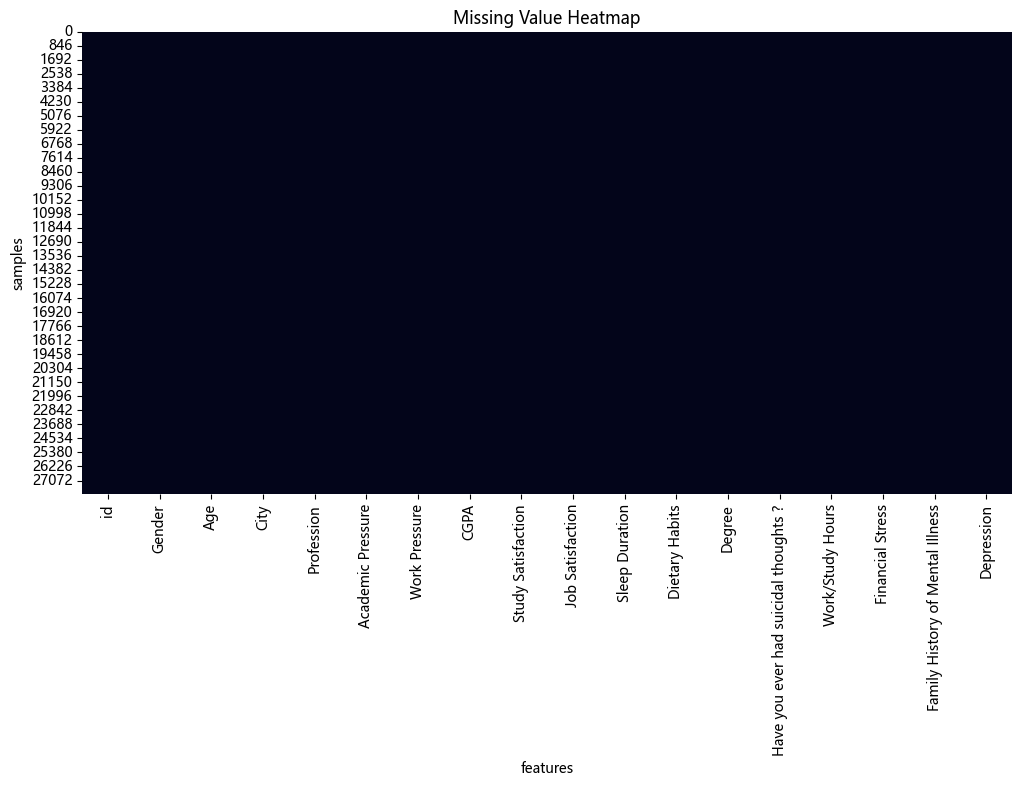

In [181]:
import matplotlib.pyplot as plt
import seaborn as sns


# # 设置中文字体（必须在绘图前设置）
# plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
# plt.rcParams['axes.unicode_minus'] = False

# 2. 缺失值分析
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Value Heatmap") # 标题：缺失值热力图
plt.xlabel("features") # x轴标签：特征
plt.ylabel("samples")  # y轴标签：样本
plt.show()


['id', 'Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Depression']
学术压力与抑郁症的关系


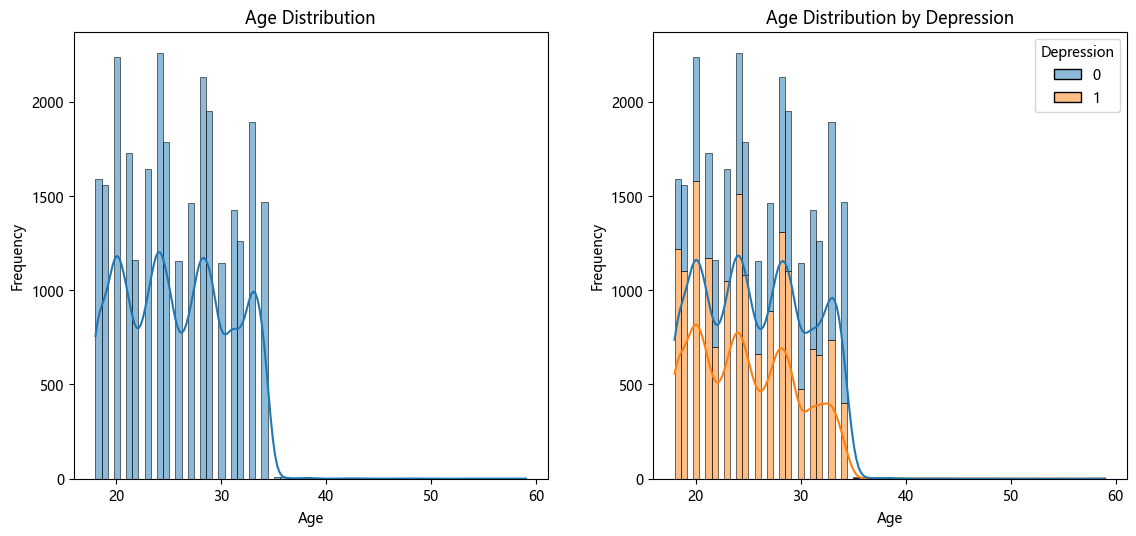

性别与抑郁症的关系


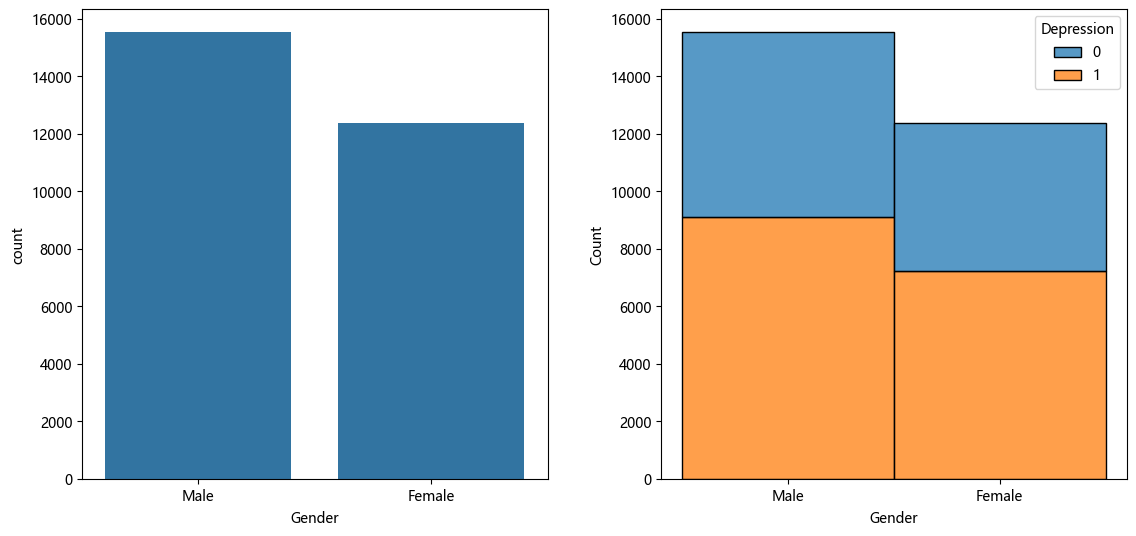

学术压力与抑郁症的关系


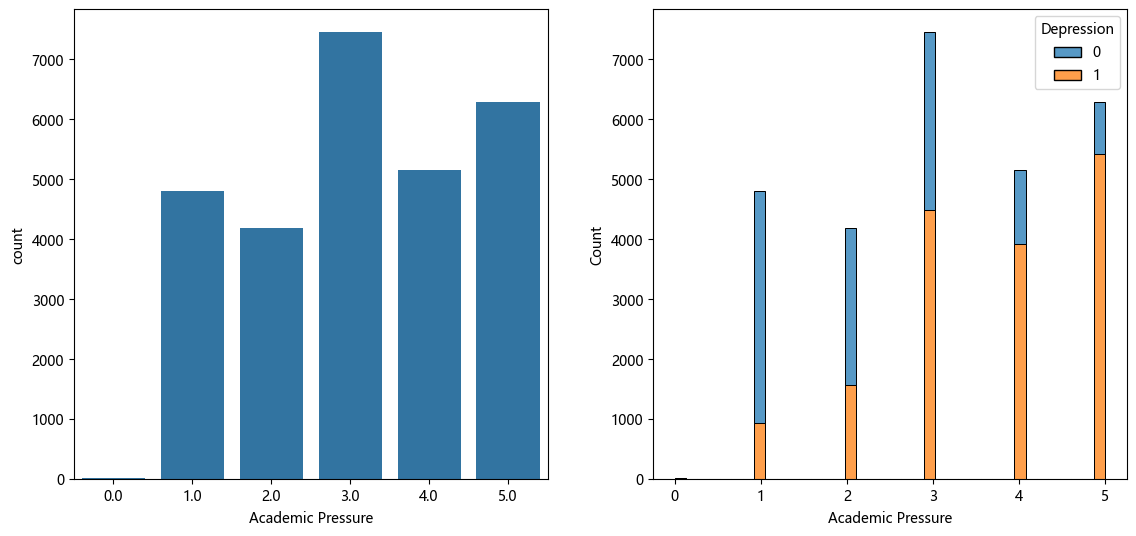

CGPA与抑郁症的关系


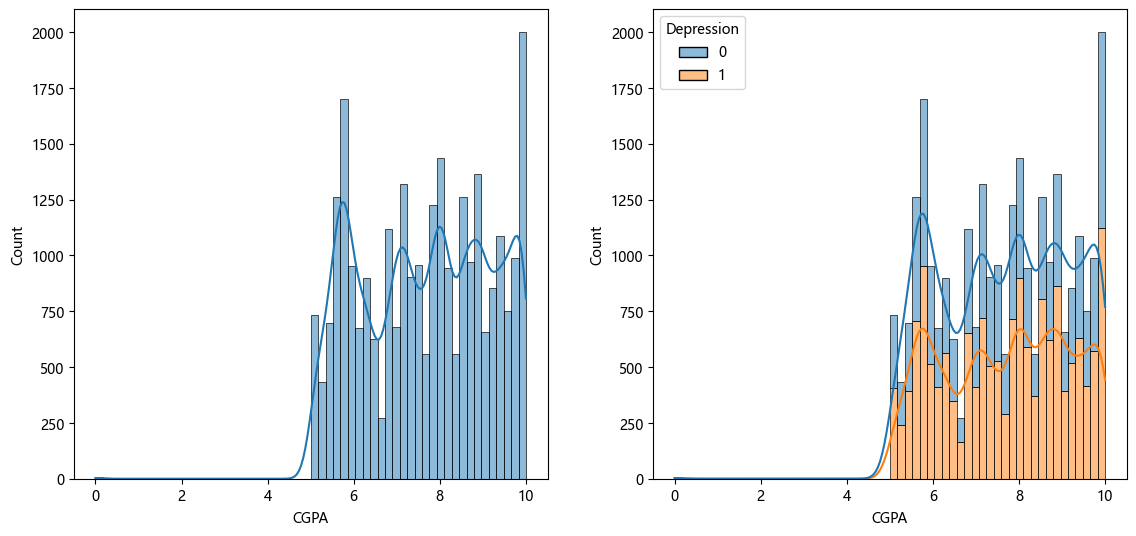

学习满意度与抑郁的关系


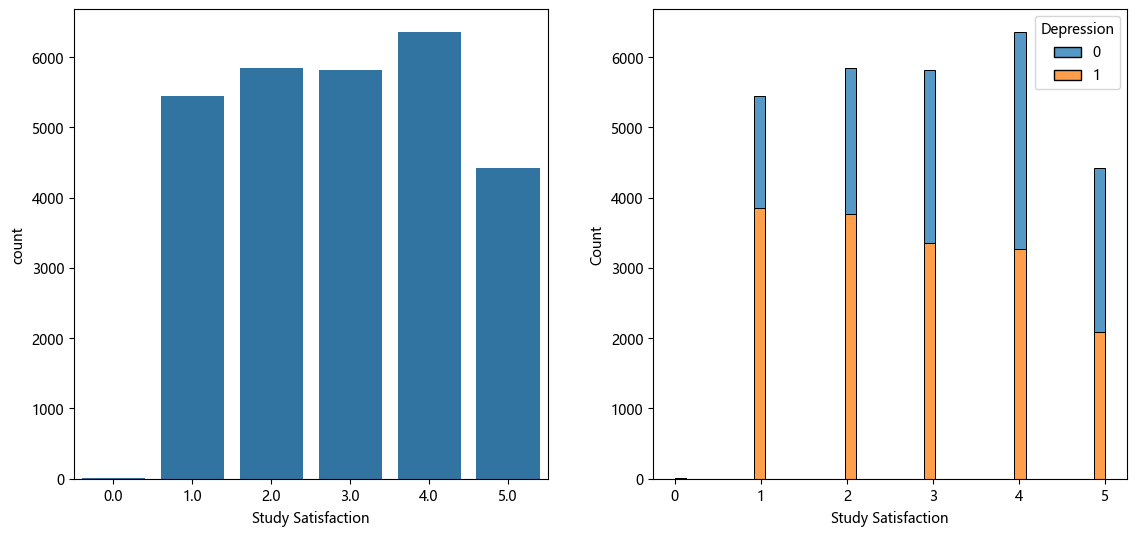

工作/学习时长与抑郁的关系


<Axes: xlabel='Work/Study Hours', ylabel='Count'>

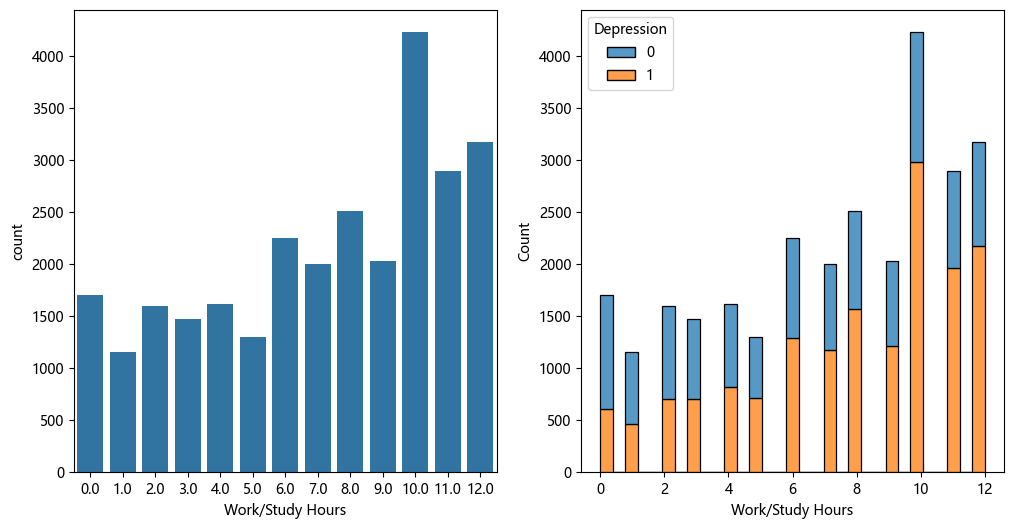

In [215]:
# 分布检测-数据图表
# 获取数字的列
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
print(num_cols)


'''
1. 绘制年龄分布图
'''
print("学术压力与抑郁症的关系")
# 一张图绘制两张图标
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(data=df['Age'],kde=True,ax=ax1 ) # 绘制年龄分布图
ax1.set_title("Age Distribution") # 标题：年龄分布
ax1.set_xlabel("Age") # x轴标签：年龄
ax1.set_ylabel("Frequency") # y轴标签：频率

# 年龄分布-抑郁症分布
sns.histplot(data=df, x='Age', hue='Depression', multiple='stack', kde=True, ax=ax2) # 绘制年龄分布图
ax2.set_title("Age Distribution by Depression") # 标题：按抑郁症分布的年龄分布
ax2.set_xlabel("Age") # x轴标签：年龄
ax2.set_ylabel("Frequency") # y轴标签：频率
# 增加间距
plt.tight_layout(pad=3.0)
plt.show() # 显示图像


'''
2. 绘制性别分布图
'''
print("性别与抑郁症的关系")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
sns.countplot(data=df, x='Gender', ax=ax1) # 绘制性别分布图
#对比性别与抑郁症的关系
sns.histplot(data=df, x='Gender', hue='Depression',multiple='stack', ax=ax2)
# 增加间距
plt.tight_layout(pad=3.0)
plt.show() # 显示图像

'''
3. 绘制学术压力分布图
'''
print("学术压力与抑郁症的关系")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
sns.countplot(data=df, x='Academic Pressure', ax=ax1) # 绘制学术压力分布图
#对比学术压力与抑郁症的关系 # 堆叠
sns.histplot(data=df, x='Academic Pressure', hue='Depression', multiple='stack',ax=ax2)
# 增加间距
plt.tight_layout(pad=3.0)
plt.show() # 显示图像


'''
4. 绘制工作压力分布图（无，工作压力均为0）
'''
# print("工作压力与抑郁症的关系")
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# sns.countplot(data=df, x='Work Pressure', ax=ax1)
# #对比工作压力与抑郁症的关系
# sns.histplot(data=df, x='Work Pressure', hue='Depression', multiple='stack', ax=ax2)
# # 增加间距
# plt.tight_layout(pad=3.0)
# plt.show() # 显示图像
'''
5. 绘制CGPA分布图
'''
print("CGPA与抑郁症的关系")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(data=df, x='CGPA', kde=True, ax=ax1)
sns.histplot(data=df, x='CGPA', hue='Depression', multiple='stack', kde=True, ax=ax2)
# 增加间距
plt.tight_layout(pad=3.0)
plt.show() # 显示图像

'''
6. 绘制学习满意度与抑郁的关系
'''
print("学习满意度与抑郁的关系")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
sns.countplot(data=df, x='Study Satisfaction', ax=ax1)
sns.histplot(data=df, x='Study Satisfaction', hue='Depression', multiple='stack', ax=ax2)
# 增加间距
plt.tight_layout(pad=3.0)
plt.show()

'''
7. 绘制工作时长与抑郁的关系
'''
print("工作/学习时长与抑郁的关系")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
sns.countplot(data=df, x='Work/Study Hours', ax=ax1)
sns.histplot(data=df, x='Work/Study Hours', hue='Depression', multiple='stack', ax=ax2)

['Gender', 'City', 'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Financial Stress', 'Family History of Mental Illness']


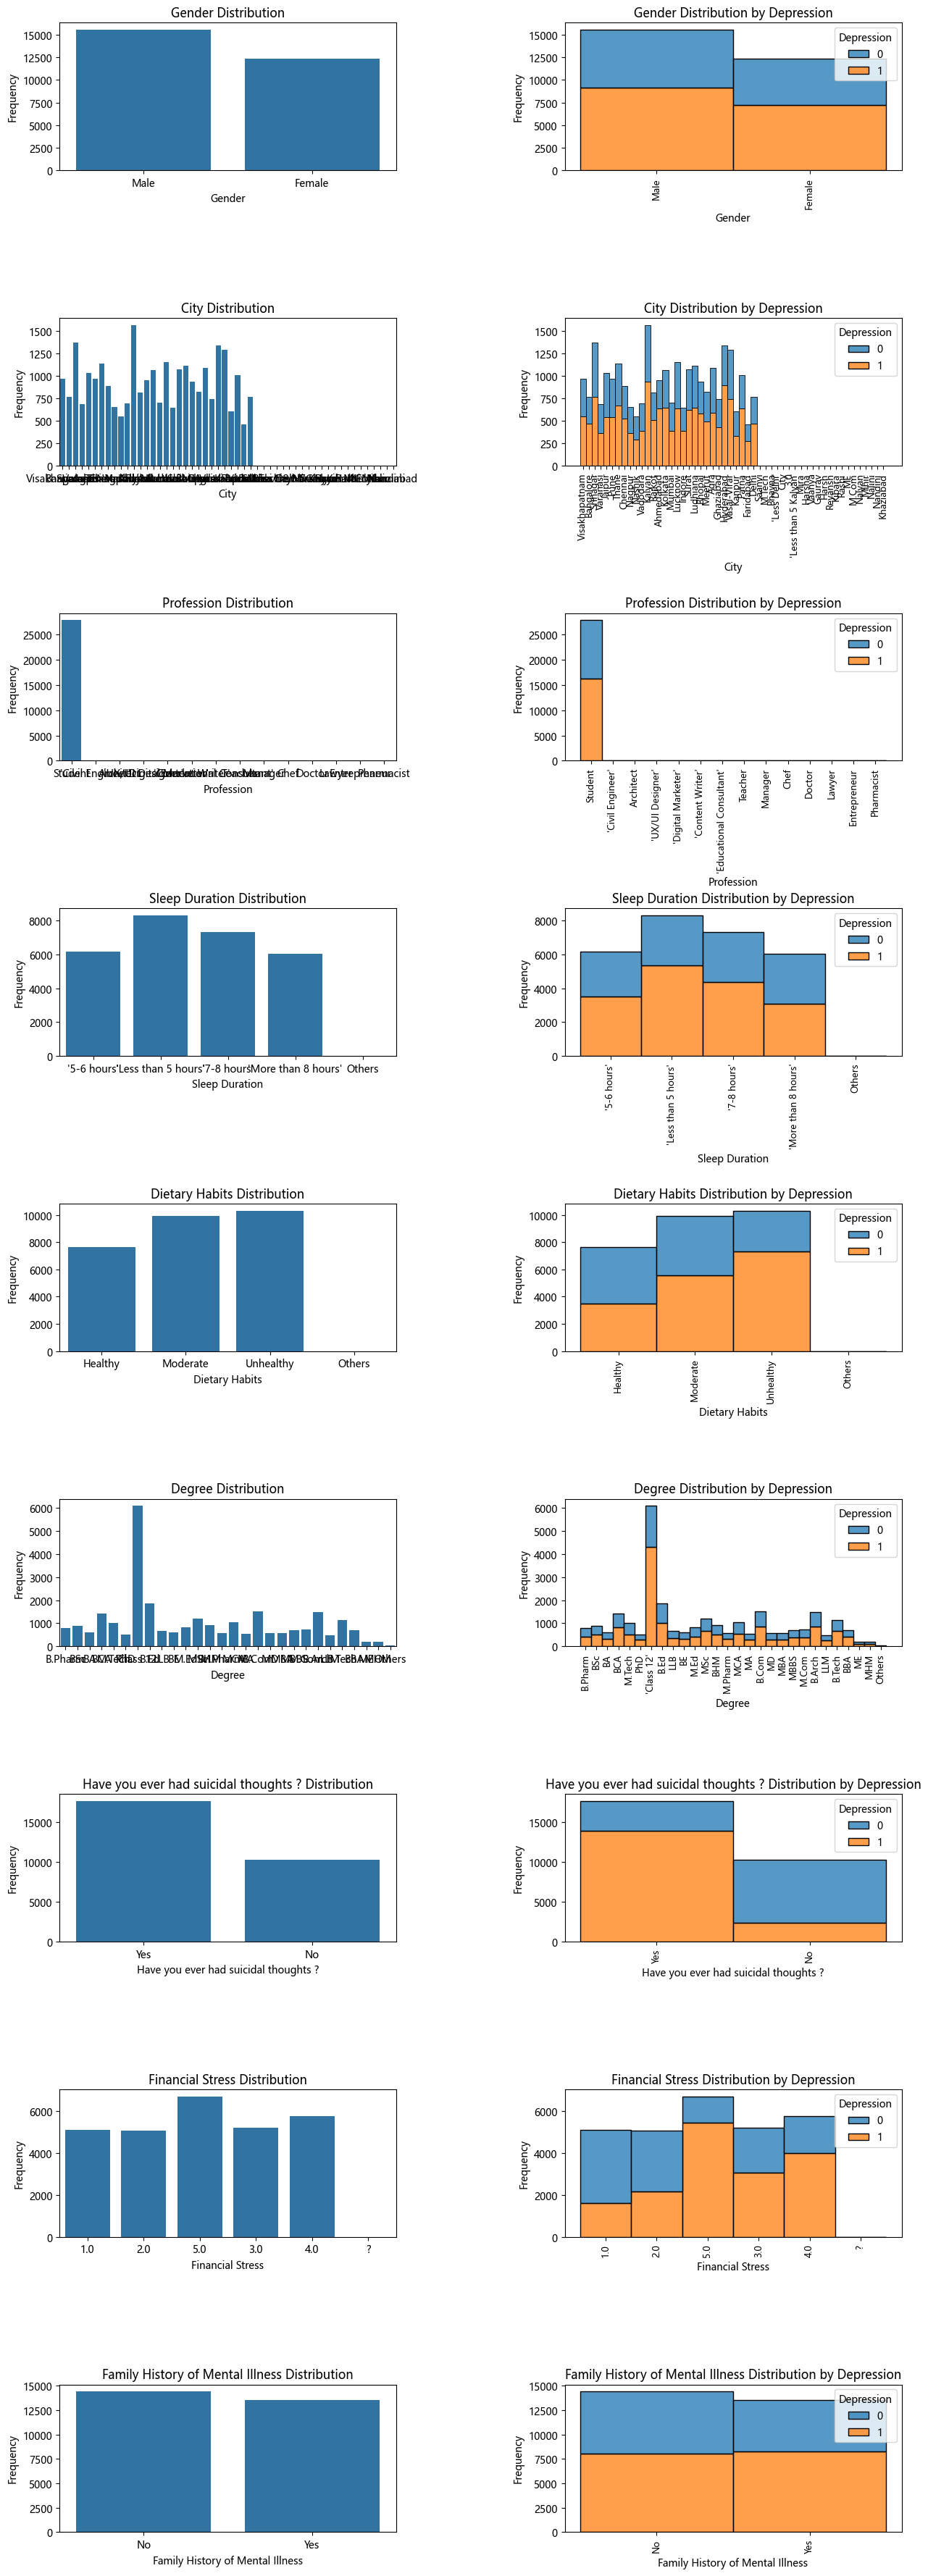

In [224]:
# 类别分析
# 获取类别数据列
cat_clos = df.select_dtypes(include=['object']).columns.to_list()
print(cat_clos)


rows = len(cat_clos)
fig, axes = plt.subplots(rows, 2, figsize=(15, 5 * rows))
for i, col in enumerate(cat_clos):
    # 绘制类别分布图
    sns.countplot(data=df, x=col, ax=axes[i][0])
    axes[i][0].set_title(f"{col} Distribution") # 标题：类别分布图
    axes[i][0].set_xlabel(col) # x轴标签：类别
    axes[i][0].set_ylabel("Frequency") # y轴标签：频率

    # 图表间隔
    plt.subplots_adjust(hspace=1)
    plt.subplots_adjust(wspace=0.5)

    # 绘制类别与抑郁症的关系图
    sns.histplot(data=df, x=col, hue='Depression', multiple='stack', ax=axes[i][1])
    axes[i][1].set_title(f"{col} Distribution by Depression") # 标题：按抑郁症分布的类别分布图
    # 标签明竖着显示
    axes[i][1].tick_params(axis='x', rotation=90, labelsize=9)  
    axes[i][1].set_xlabel(col ) # x轴标签：类别
    axes[i][1].set_ylabel("Frequency") # y轴标签：频率


## 2. 构建模型

### 2.1 机器学习模型

#### 2.1.1  决策树分类模型

In [ ]:
'''
使用决策树对数据进行预测
'''
#导入sklearn库，用于数据预处理
from sklearn.model_selection import train_test_split
# 拆分特征和标签
x=df.drop('Depression',axis=1)
y=df['Depression']
# 获取数值型和分类型数据
num_cols=x.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols=x.select_dtypes(include=['object']).columns.tolist()
# 拆分数据集
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# 数据预处理，导入包
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
# 数据预处理
# ColumnTransformer用于对不同类型的数据进行不同的预处理(适用于混合数据类型的数据集)
# StandardScaler用于数值型数据的标准化 （适用标准化方法对数值型数据进行标准化）
# OneHotEncoder用于分类型数据的独热编码 （适用独热编码对分类型数据进行编码）
# OneHotEncoder(drop='first')用于避免虚拟变量陷阱（避免多重共线性）（线性回归等模型必须）
# handle_unknown='ignore'用于处理未知类别（避免错误）
# 原始数据 → [数值列: 标准化] + [分类列: 独热编码] → 合并后的特征矩阵
preprocessing = ColumnTransformer([('scaler',StandardScaler(),num_cols),
                                  ('encoder',OneHotEncoder(drop='first',handle_unknown='ignore'),cat_cols)])

# 训练模型
# 导入sklearn库，用于模型训练和评估
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
model=Pipeline([('pre',preprocessing),
               ('model',DecisionTreeClassifier())])
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
print(f'Accuracy Score: {accuracy_score(y_test,y_pred) *100 :.2f}')

Accuracy Score: 75.76


c:\Users\22336\anaconda3\envs\AI\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


#### 2.1.2 其他模型进行分类

In [226]:
# 内容同上
from sklearn.model_selection import train_test_split
x=df.drop('Depression',axis=1)
y=df['Depression']
num_cols=x.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols=x.select_dtypes(include=['object']).columns.tolist()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
preprocessing = ColumnTransformer([('scaler',StandardScaler(),num_cols),
                                  ('encoder',OneHotEncoder(drop='first',handle_unknown='ignore'),cat_cols)])

# 导入各种模型
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Classifier': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

# 遍历使用，依次进行评估
from sklearn.pipeline import Pipeline
results={}
for name,model in models.items():
    pipeline=Pipeline([('pre',preprocessing),
                      ('model',model)])
    pipeline.fit(x_train,y_train)
    y_pred=pipeline.predict(x_test)
    acc=accuracy_score(y_test,y_pred)
    results[name]=acc
    print(f'Accuracy score for {name} is {acc *100 :.2f}')

c:\Users\22336\anaconda3\envs\AI\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Accuracy score for Logistic Regression is 83.95


c:\Users\22336\anaconda3\envs\AI\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Accuracy score for Decision Tree is 75.52


c:\Users\22336\anaconda3\envs\AI\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Accuracy score for Random Forest is 82.67


c:\Users\22336\anaconda3\envs\AI\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Accuracy score for Support Vector Classifier is 83.39


c:\Users\22336\anaconda3\envs\AI\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Accuracy score for K-Nearest Neighbors is 79.82
Accuracy score for Gradient Boosting is 83.98


c:\Users\22336\anaconda3\envs\AI\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### 2.2 深度学习模型

In [ ]:
# 内容同上，数据预处理部分相同
from sklearn.model_selection import train_test_split
x=df.drop('Depression',axis=1)
y=df['Depression']
num_cols=x.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols=x.select_dtypes(include=['object']).columns.tolist()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
preprocessing = ColumnTransformer([('scaler',StandardScaler(),num_cols),
                                  ('encoder',OneHotEncoder(drop='first',handle_unknown='ignore'),cat_cols)])



ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                 ['id', 'Age', 'Academic Pressure',
                                  'Work Pressure', 'CGPA', 'Study Satisfaction',
                                  'Job Satisfaction', 'Work/Study Hours']),
                                ('encoder',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 ['Gender', 'City', 'Profession',
                                  'Sleep Duration', 'Dietary Habits', 'Degree',
                                  'Have you ever had suicidal thoughts ?',
                                  'Financial Stress',
                                  'Family History of Mental Illness'])])


In [242]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

# 1. 数据预处理并转换为PyTorch张量 ==============================
# 应用预处理
X_train_processed = preprocessing.fit_transform(x_train)
X_test_processed = preprocessing.transform(x_test)

# 转换为密集数组（如果使用稀疏矩阵需特殊处理）
X_train_dense = X_train_processed.toarray() if hasattr(X_train_processed, "toarray") else X_train_processed
X_test_dense = X_test_processed.toarray() if hasattr(X_test_processed, "toarray") else X_test_processed

# 转换为PyTorch张量
X_train_tensor = torch.tensor(X_train_dense, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)  # BCE需要float类型
X_test_tensor = torch.tensor(X_test_dense, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# 2. 创建PyTorch数据集 ========================================
class DepressionDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = DepressionDataset(X_train_tensor, y_train_tensor)
test_dataset = DepressionDataset(X_test_tensor, y_test_tensor)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# 3. 定义神经网络模型 ========================================
class DepressionClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        return self.net(x)

# 获取输入维度（处理后的特征数）
input_dim = X_train_tensor.shape[1]
model = DepressionClassifier(input_dim)

# 4. 训练配置 ================================================
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

loss_fn = nn.BCEWithLogitsLoss()  # 自动包含sigmoid
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# 5. 训练循环 ================================================
EPOCHS = 100

for epoch in range(EPOCHS):
    # 训练阶段
    model.train()
    train_loss, correct = 0, 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # 前向传播
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # 梯度裁剪
        optimizer.step()
        
        # 统计指标
        train_loss += loss.item()
        predicted = torch.sigmoid(y_pred) > 0.5
        correct += (predicted == y_batch).sum().item()
    
    # 验证阶段
    model.eval()
    test_loss, test_correct = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            test_loss += loss_fn(y_pred, y_batch).item()
            predicted = torch.sigmoid(y_pred) > 0.5
            test_correct += (predicted == y_batch).sum().item()
    
    # 输出指标
    train_acc = correct / len(train_dataset)
    test_acc = test_correct / len(test_dataset)
    if epoch % 1 == 0:
        print(f"Epoch {epoch:2}: "
              f"Train Loss: {train_loss/len(train_loader):.4f} | Acc: {train_acc:.2%} | "
              f"Test Loss: {test_loss/len(test_loader):.4f} | Test Acc: {test_acc:.2%}")

# 最终评估
model.eval()
with torch.no_grad():
    y_probs = torch.sigmoid(model(X_test_tensor.to(device)))
    y_pred = (y_probs > 0.5).float().cpu()
    final_acc = (y_pred == y_test_tensor).float().mean()
print(f"\nFinal Test Accuracy: {final_acc:.2%}")

c:\Users\22336\anaconda3\envs\AI\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Epoch  0: Train Loss: 0.4011 | Acc: 81.80% | Test Loss: 0.3753 | Test Acc: 83.39%
Epoch  1: Train Loss: 0.3558 | Acc: 84.60% | Test Loss: 0.3764 | Test Acc: 83.80%
Epoch  2: Train Loss: 0.3518 | Acc: 84.87% | Test Loss: 0.3683 | Test Acc: 83.61%
Epoch  3: Train Loss: 0.3478 | Acc: 85.04% | Test Loss: 0.3686 | Test Acc: 83.95%
Epoch  4: Train Loss: 0.3460 | Acc: 85.09% | Test Loss: 0.3681 | Test Acc: 83.53%
Epoch  5: Train Loss: 0.3444 | Acc: 85.35% | Test Loss: 0.3676 | Test Acc: 83.78%
Epoch  6: Train Loss: 0.3415 | Acc: 85.39% | Test Loss: 0.3736 | Test Acc: 83.50%
Epoch  7: Train Loss: 0.3423 | Acc: 85.29% | Test Loss: 0.3707 | Test Acc: 83.71%
Epoch  8: Train Loss: 0.3398 | Acc: 85.52% | Test Loss: 0.3693 | Test Acc: 83.59%
Epoch  9: Train Loss: 0.3373 | Acc: 85.69% | Test Loss: 0.3685 | Test Acc: 83.50%
Epoch 10: Train Loss: 0.3370 | Acc: 85.60% | Test Loss: 0.3703 | Test Acc: 83.37%
Epoch 11: Train Loss: 0.3365 | Acc: 85.65% | Test Loss: 0.3690 | Test Acc: 83.28%
Epoch 12: Train 